Implemente funções que calculem interpolação polinomial e spline cúbica a partir da solução de sistemas de equações. Construa nas suas funções a capacidade de receber os dados de entrada e gerar as matrizes e vetores automaticamente, sem ter de especificá-los manualmente.

Coeficientes do polinômio interpolador: [ 0.         -6.66666667 12.33333333 -5.33333333  0.66666667]


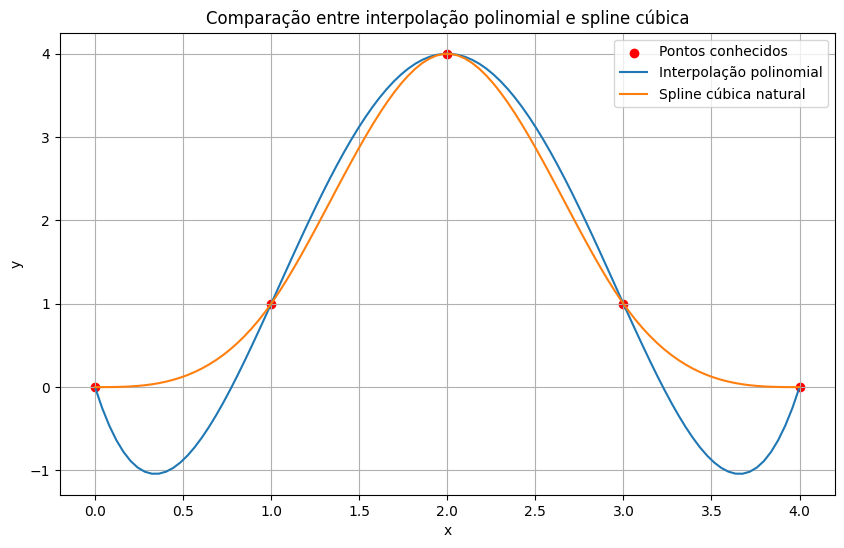

In [6]:
import numpy as np

def interpolacao_polinomial(x, y):
    """
    Interpolação polinomial usando sistema linear

    Parâmetros:
    x : array-like, pontos x conhecidos
    y : array-like, pontos y conhecidos (f(x))

    Retorna:
    coeficientes : array, coeficientes do polinômio interpolador
    """
    n = len(x)
    # Verifica se temos o mesmo número de pontos x e y
    if len(y) != n:
        raise ValueError("x e y devem ter o mesmo tamanho")

    # Construir a matriz de Vandermonde
    A = np.vander(x, increasing=True)

    # Resolver o sistema linear A * coeficientes = y
    coeficientes = np.linalg.solve(A, y)

    return coeficientes

def avaliar_polinomio(coef, x):
    """
    Avalia um polinômio nos pontos x

    Parâmetros:
    coef : array, coeficientes do polinômio (do menor para maior grau)
    x : array-like, pontos onde avaliar

    Retorna:
    valores : array, valores do polinômio nos pontos x
    """
    return np.polyval(coef[::-1], x)

def spline_cubica_natural(x, y):
    """
    Spline cúbica natural usando sistema tridiagonal

    Parâmetros:
    x : array-like, pontos x conhecidos (devem estar em ordem crescente)
    y : array-like, pontos y conhecidos (f(x))

    Retorna:
    coeficientes : lista de arrays, coeficientes para cada segmento da spline
    """
    n = len(x)
    if len(y) != n:
        raise ValueError("x e y devem ter o mesmo tamanho")
    if n < 3:
        raise ValueError("São necessários pelo menos 3 pontos para spline cúbica")

    # Verificar se x está em ordem crescente
    if not np.all(np.diff(x) > 0):
        raise ValueError("Os pontos x devem estar em ordem estritamente crescente")

    h = np.diff(x)
    delta = np.diff(y) / h

    # Construir o sistema tridiagonal para as segundas derivadas (M)
    # Forma: A * M = b
    A = np.zeros((n-2, n-2))
    b = np.zeros(n-2)

    # Preencher a matriz A e o vetor b
    for i in range(n-2):
        if i > 0:
            A[i, i-1] = h[i]
        A[i, i] = 2 * (h[i] + h[i+1])
        if i < n-3:
            A[i, i+1] = h[i+1]

        b[i] = 6 * (delta[i+1] - delta[i])

    # Resolver o sistema para M (segundas derivadas nos pontos internos)
    M_interno = np.linalg.solve(A, b)

    # Spline natural: M0 = Mn = 0
    M = np.zeros(n)
    M[1:-1] = M_interno

    # Calcular coeficientes para cada segmento
    coeficientes = []
    for i in range(n-1):
        a = (M[i+1] - M[i]) / (6 * h[i])
        b = M[i] / 2
        c = delta[i] - h[i] * (2 * M[i] + M[i+1]) / 6
        d = y[i]
        coeficientes.append(np.array([a, b, c, d]))

    return coeficientes, x

def avaliar_spline(coef, x_knots, x_avaliar):
    """
    Avalia a spline cúbica nos pontos x_avaliar

    Parâmetros:
    coef : lista de arrays, coeficientes da spline
    x_knots : array, pontos x originais
    x_avaliar : array-like, pontos onde avaliar

    Retorna:
    valores : array, valores da spline nos pontos x_avaliar
    """
    x_avaliar = np.asarray(x_avaliar)
    valores = np.zeros_like(x_avaliar)

    for i, xi in enumerate(x_avaliar):
        # Encontrar o intervalo correto
        idx = np.searchsorted(x_knots, xi) - 1
        idx = max(0, min(idx, len(coef)-1))

        # Coeficientes para este segmento
        a, b, c, d = coef[idx]

        # Delta x em relação ao início do segmento
        dx = xi - x_knots[idx]

        # Avaliar o polinômio cúbico
        valores[i] = a*dx**3 + b*dx**2 + c*dx + d

    return valores

  # Dados de exemplo
x = np.array([0, 1, 2, 3, 4])
y = np.array([0, 1, 4, 1, 0])

# Interpolação polinomial
coef_poli = interpolacao_polinomial(x, y)
print("Coeficientes do polinômio interpolador:", coef_poli)

# Avaliar em novos pontos
x_new = np.linspace(0, 4, 100)
y_poli = avaliar_polinomio(coef_poli, x_new)

# Spline cúbica natural
coef_spline, x_knots = spline_cubica_natural(x, y)
y_spline = avaliar_spline(coef_spline, x_knots, x_new)

# Plotar resultados (opcional - requer matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Pontos conhecidos')
plt.plot(x_new, y_poli, label='Interpolação polinomial')
plt.plot(x_new, y_spline, label='Spline cúbica natural')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparação entre interpolação polinomial e spline cúbica')
plt.grid(True)

plt.show()